
📊 Word Frequency Table (6-Month Periods):
              1689-H1  1689-H2  1690-H1  1690-H2  1691-H1  1691-H2
Word                                                              
ireland            12       22       20       14        6        2
james               5       22        8       11        0        4
scotland           10        9       14        9        4        3
mackay              9       26        7        5        0        0
prisoner            3       19       12        4        6        1
french              4        9        6        8       11        5
dundee             11       31        0        0        0        0
enemies             3       12        7       14        1        2
highlanders         2        7        6       10        8        6
mail                1       10        5       14        5        2
plot                0        7        9       20        1        0
intelligence        4        9        9        7        2        3
highlands          

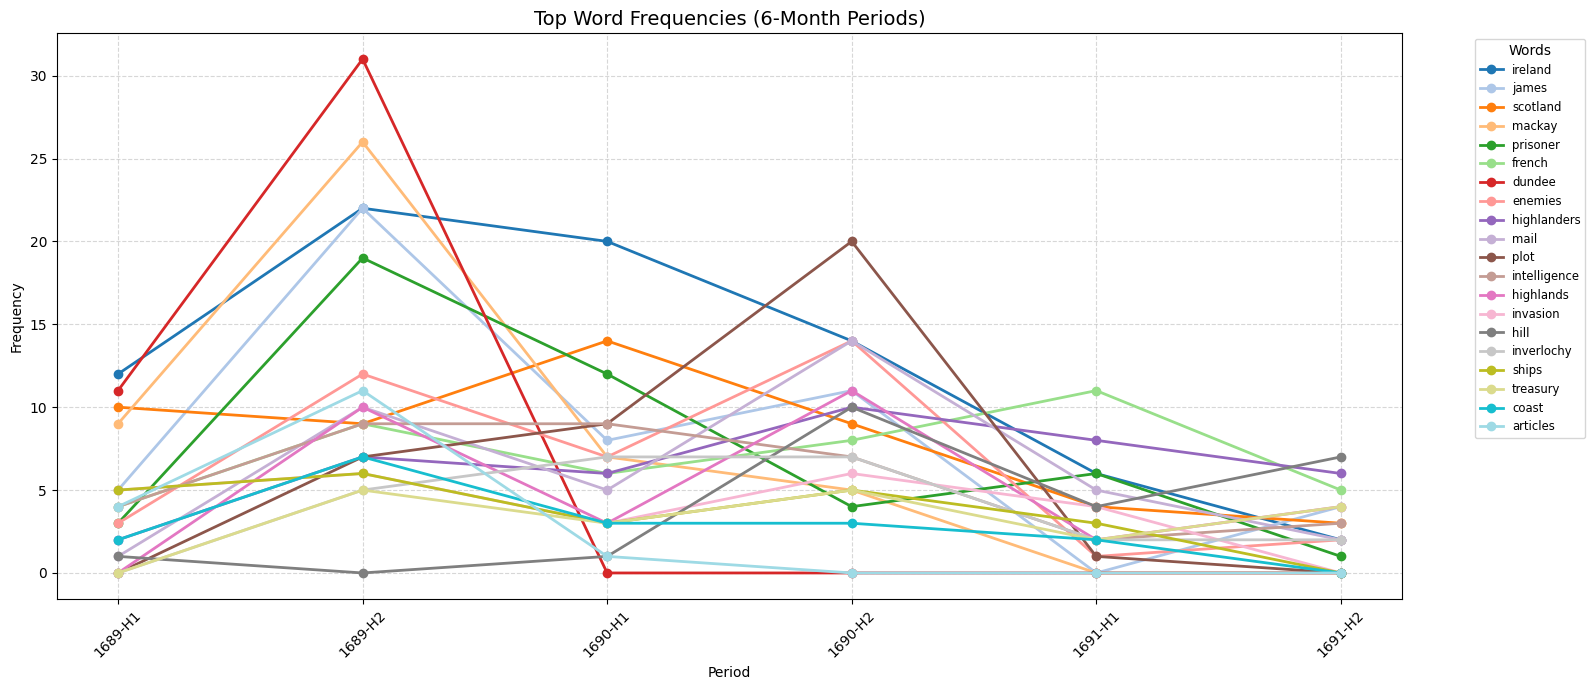

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
import sys

# Define the CSV file URL
csv_file_url = 'https://raw.githubusercontent.com/gilliansmac92/networkingletters/main/data/new-data/dated-topics-levenmelvillepapers.csv'

# Simple custom stopword list (in lowercase)
custom_stop_words = set([
    'king', 'service', 'parliament', 'friendship', 'duty', 'favor', 'honor', 'religion',
    'loyalty', 'honesty', 'appointment', 'interest', 'friends', 'guilty', 'edinburgh', 'skelmorlie',
    'church', 'privy', 'council', 'government', 'ministers', 'assembly', 'club', 'castle', 'hamilton'
])

def preprocess_keywords(text):
    """Lowercases and returns text for vectorization."""
    return text.lower()

def load_data(csv_url):
    df = pd.read_csv(csv_url)

    if 'DATE' not in df.columns or 'TOPICS' not in df.columns:
        raise ValueError("CSV must contain 'DATE' and 'TOPICS' columns.")

    df['date'] = pd.to_datetime(df['DATE'], errors='coerce')
    df = df.dropna(subset=['date', 'TOPICS'])

    df['year'] = df['date'].dt.year
    # Add half-year period column
    df['period'] = df['year'].astype(str) + '-H' + ((df['date'].dt.month > 6).astype(int) + 1).astype(str)

    df['topics'] = df['TOPICS'].astype(str).apply(preprocess_keywords)

    return df

def count_words_by_period(df, periods):
    word_freq_by_period = defaultdict(Counter)
    vectorizer = CountVectorizer(stop_words='english')

    for period in periods:
        texts = df[df['period'] == period]['topics']
        if texts.empty:
            continue

        X = vectorizer.fit_transform(texts)
        vocab = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1

        # Apply custom stop word filtering
        word_counts = {word: count for word, count in zip(vocab, counts)
                       if word not in custom_stop_words}
        word_freq_by_period[period] = Counter(word_counts)

    return word_freq_by_period

def count_words_by_year(df, years):
    word_freq_by_year = defaultdict(Counter)
    vectorizer = CountVectorizer(stop_words='english')  # We'll filter custom later

    for year in years:
        year_texts = df[df['year'] == year]['topics']
        if year_texts.empty:
            continue

        X = vectorizer.fit_transform(year_texts)
        vocab = vectorizer.get_feature_names_out()
        counts = X.sum(axis=0).A1

        # Apply custom stop word filtering
        word_counts = {word: count for word, count in zip(vocab, counts)
                       if word not in custom_stop_words}
        word_freq_by_year[year] = Counter(word_counts)

    return word_freq_by_year

def get_top_words_across_years(word_freq_by_year, top_n):
    total_counts = Counter()
    for yearly_counts in word_freq_by_year.values():
        total_counts.update(yearly_counts)
    return [word for word, _ in total_counts.most_common(top_n)]

# Moved function definitions before where they are called
def print_word_frequency_table(word_freq_by_period, top_words, periods):
    data = {
        word: [word_freq_by_period.get(p, {}).get(word, 0) for p in periods]
        for word in top_words
    }
    df_table = pd.DataFrame(data, index=periods).transpose()
    df_table.index.name = 'Word'
    print("\n📊 Word Frequency Table (6-Month Periods):")
    print(df_table)

# Moved function definitions before where they are called
def plot_word_trends(word_freq_by_period, top_words, periods):
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    plt.figure(figsize=(16, 7))

    # Use a categorical colormap and repeat colors if needed
    cmap = plt.get_cmap('tab20')  # Can replace with 'Set3', 'hsv', etc.
    base_colors = [cmap(i) for i in range(cmap.N)]
    colors = [base_colors[i % len(base_colors)] for i in range(len(top_words))]

    for i, word in enumerate(top_words):
        freqs = [word_freq_by_period.get(p, {}).get(word, 0) for p in periods]
        plt.plot(periods, freqs, marker='o', label=word, color=colors[i], linewidth=2)

    plt.title("Top Word Frequencies (6-Month Periods)", fontsize=14)
    plt.xlabel("Period")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


def main_with_periods(csv_url, top_n=20):
    df = load_data(csv_url)
    periods = sorted(df['period'].unique())
    word_freq_by_period = count_words_by_period(df, periods)
    # Ensure we pass the correct dictionary structure to get_top_words_across_years
    # It currently expects a dictionary where values are Counters, which is correct
    top_words = get_top_words_across_years(word_freq_by_period, top_n)
    print_word_frequency_table(word_freq_by_period, top_words, periods)
    plot_word_trends(word_freq_by_period, top_words, periods)

if __name__ == "__main__":
    if len(sys.argv) > 1 and sys.argv[1] != '-f':
        csv_input = sys.argv[1]
    else:
        csv_input = csv_file_url

    main_with_periods(csv_input, top_n=20)